In [0]:
import re
import spacy
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

from wordcloud import WordCloud
from bs4 import BeautifulSoup

from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import ClassifierChain
from sklearn.base import BaseEstimator, ClassifierMixin

In [246]:
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag_sents, pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import RegexpTokenizer

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Задача

По данным заголовкам и текстам вопросов с $\text{Stack Overflow}$ научиться предсказывать к каким тэгам отнести вопрос.

## Чтение данных


In [0]:
X_train = pd.read_csv('train/X_train.csv')
Y_train = pd.read_csv('train/Y_train.csv')

In [4]:
display(X_train.head())
display(Y_train.head())

,id,title,body
0,56685310,onNext method doesn't fire on observable,<p>I have a method that returns an observable ...
1,55893408,TextView not positioning under ImagevVew in `C...,<p>I am developing android news app. and in my...
2,55807871,Deploying a firebase functions,<p>i'm trying to deploy my functions on fireba...
3,54842410,Share C++11 mutex on shared memory,<p>I want to avoid data racing in a shared mem...
4,55572776,Cleaning data: How to iterate through a list f...,<p>I am trying to iterate through a list of da...


,Id,Expected
0,56685310,angular
1,55893408,android java
2,55807871,firebase
3,54842410,c++
4,55572776,list python


Уберем дубликаты

In [0]:
X_train.drop_duplicates(['title', 'body'], inplace=True)
Y_train = Y_train.loc[X_train.index]

Проверим, что все $\text{id}$ уникальны

In [6]:
X_train.shape[0] == X_train.id.nunique()

True

Возьмем малую подвыбрку данных, чтобы сократить вычислительное время

In [0]:
X_train = X_train.iloc[:100000]
Y_train = Y_train.iloc[:100000]

## Предобработка данных

### Выделение тэгов

Определим все возможные тэги вопросов

In [0]:
tags_vectorizer = CountVectorizer(tokenizer= lambda x: x.split(), binary=True)

In [0]:
tags_vect = tags_vectorizer.fit_transform(Y_train.Expected)

In [0]:
tags = tags_vectorizer.get_feature_names()

In [0]:
tags_counts = pd.Series(tags_vect.sum(axis=0).A1, index=tags)

In [0]:
tags_counts.sort_values(ascending=False, inplace=True)

Посмотрим на частоты тэгов

Number of tags = 68


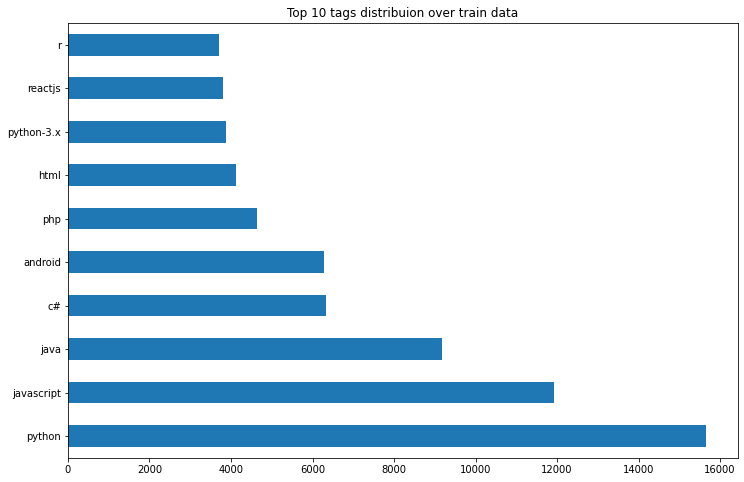

In [19]:
print(f'Number of tags = {len(tags)}')
tags_counts[:10].plot(kind='barh', figsize=(12, 8))
plt.title('Top 10 tags distribuion over train data')
plt.show()

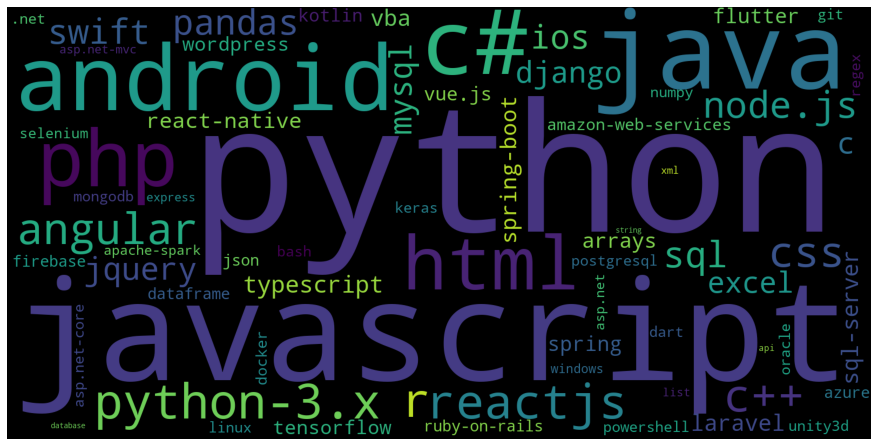

In [20]:
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tags_counts)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

Посмотрим на распределние числа тэгов в вопросах

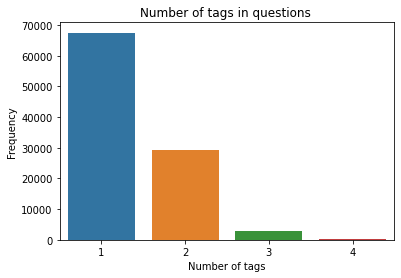

In [21]:
sns.countplot(tags_vect.sum(axis=1).A1)
plt.title("Number of tags in questions ")
plt.xlabel("Number of tags")
plt.ylabel("Frequency")
plt.show()

Закодируем тэги

In [0]:
tags_encoder = LabelEncoder().fit(tags)

### Выделение текста и кода из тела вопроса

In [0]:
def extract_from_body(body, tag):
    soup = BeautifulSoup(body, 'lxml')
    return ' '.join(t.text for t in soup.find_all(tag))

### Очистка и нормализация вопроса

Подготовим регулярные выражаения и возможные нормализаторы

Регулярки

In [0]:
cpp = re.compile(r'c\s*\+\+|c-*plus-*plus')
csharp = re.compile(r'c\s*#')
python3 = re.compile(r'py(?:thon)?\s*-*3(?:\.\d+)*')
aspnet = re.compile(r'asp\.net|aspnet|asp-net|asp\s*net')

In [0]:
program_lang_regexs = [('cpp', cpp), ('csharp', csharp),\
                       ('pythonthree', python3), ('aspnet', aspnet)]

In [0]:
replace_by_space_re = re.compile(r'[^a-z ]+')

Стоп-слова

In [0]:
stop_words = set(stopwords.words('english'))

Условия на токены

In [0]:
def token_text_condition(token, stop_words):
    return token not in stop_words and len(token) >= 2\
           or token == 'c' or token =='r' # because 'c' and 'r' are names of programming languages

In [0]:
def token_code_condition(token, stop_words):
    return token not in stop_words

NLTK стемминг

In [0]:
def nltk_stem_text(stemmer, tokens, token_condition):
    stem_tokens = (stemmer.stem(token) for token in tokens\
                   if token_condition(token, stop_words))
    return ' '.join(stem_tokens)

In [0]:
stemmer = SnowballStemmer('english')

NLTK лемминг

In [0]:
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']


def penn_to_wordnet(tag):
    if is_adjective(tag):
        return wordnet.ADJ
    elif is_noun(tag):
        return wordnet.NOUN
    elif is_adverb(tag):
        return wordnet.ADV
    elif is_verb(tag):
        return wordnet.VERB
    return wordnet.NOUN

In [0]:
def nltk_lemmatize_text(lemmer, clean_text, token_condition):
    lemmas = (lemmer.lemmatize(token, penn_to_wordnet(pos)) for token, pos \
              in pos_tag(word_tokenize(clean_text) , lang='eng')\
              if token_condition(token, stop_words))
    return ' '.join(lemmas)

In [0]:
lemmer = WordNetLemmatizer()

spaCy лемминг

In [0]:
def scapy_lemmatize_text(nlp, clean_text, token_condition):
    return ' '.join(token.lemma_ for token in nlp(clean_text)\
                    if token_condition(token.lemma_, stop_words)\
                    and token.lemma_ != '-PRON-')

In [0]:
nlp = spacy.load('en')

Протестируем

In [37]:
sentence = X_train['title'][15].lower()
print(f'Origin sentence : {sentence}')
print(f'NLTK lemma : {nltk_lemmatize_text(lemmer, sentence, token_text_condition)}')
print(f'spaCy lemma : {scapy_lemmatize_text(nlp, sentence, token_text_condition)}')
print(f'Stem : {nltk_stem_text(stemmer, sentence.split(), token_text_condition)}')

Origin sentence : how to set default class property value with a variable from another php file?
NLTK lemma : set default class property value variable another php file
spaCy lemma : set default class property value variable another php file
Stem : set default class properti valu variabl anoth php file?


#### Текст

In [0]:
def clean_text(text):
    text = text.lower()
    for lang_name, lang_re in program_lang_regexs:
        text = lang_re.sub(lang_name, text)
    text = replace_by_space_re.sub(' ', text)
    return text

In [0]:
def clean_and_normalize_text(text, method='nltk_lemma'):
    text = clean_text(text)
    if method == 'nltk_lemma':
        return nltk_lemmatize_text(lemmer, text, token_text_condition)
    if method == 'nltk_stem':
        return nltk_stem_text(stemmer, text.split(), token_text_condition)
    if method == 'spacy_lemma':
        return scapy_lemmatize_text(nlp, text, token_text_condition)

#### Код

Токенайзер для кода

In [0]:
code_tokenizer = \
nltk.tokenize.RegexpTokenizer(r'(?![\d\:\|\s])(?:\w{2,}|\+\+|\*\*|::|\&\&|\/\/|</|<\!|<\?|\W)')

In [0]:
def clean_code(code):
    code = code.lower()
    for lang_name, lang_re in program_lang_regexs:
        code = lang_re.sub(lang_name, code)
    return code

In [0]:
def clean_and_normalize_code(code):
    code = clean_code(code)
    return nltk_stem_text(stemmer, code_tokenizer.tokenize(code), token_code_condition)

### Препроцессинг

In [0]:
def preprocess(X, Y=None, normalize_method='nltk_lemma'):
    if Y is not None:
        Y['Expected'] = Y['Expected'].apply(lambda tags : tags_encoder.transform(tags.split()))
    
    X['body_text'] = X['body'].apply(lambda body: extract_from_body(body, 'p'))
    X['body_code'] = X['body'].apply(lambda body: extract_from_body(body, 'code'))
    X.drop(['body'], axis=1, inplace=True)
    X['body_text'] = X['body_text'].apply(lambda text: clean_and_normalize_text(text, normalize_method))
    X['body_code'] = X['body_code'].apply(clean_and_normalize_code)
    X['title'] = X['title'].apply(lambda text: clean_and_normalize_text(text, normalize_method))
    return X, Y

Протестируем

In [0]:
X = X_train.iloc[:5].copy()
Y = Y_train.iloc[:5].copy()

In [45]:
for sample in preprocess(X, Y, normalize_method='nltk_stem'):
    display(sample)

,id,title,body_text,body_code
0,56685310,onnext method fire observ,method return observ call anoth method process...,data basedata [ ] = [ ] ; initdata ( ) { . dat...
1,55893408,textview posit imagevvew coordinatorlayout,develop android news app list implement imag t...,textview textview imageview coordinatorlayout ...
2,55807871,deploy firebas function,tri deploy function firebas say parss error un...,
3,54842410,share cpp mutex share memori,want avoid data race share memori buffer mani ...,std mutex memcpi
4,55572776,clean data iter list find item contain string ...,tri iter list data clean small part list want ...,"line = [ ' wirkstofflist – ' , ' ' , ' ' , ' g..."


,Id,Expected
0,56685310,[3]
1,55893408,"[2, 28]"
2,55807871,[23]
3,54842410,[14]
4,55572776,"[36, 46]"


Применим преобразования к данным

In [0]:
X_train, Y_train = preprocess(X_train, Y_train, normalize_method='nltk_stem')

Выделим обучающую и тестовую выборки

In [0]:
Xtrain, Xtest, Ytrain, Ytest =\
 train_test_split(X_train.drop(['id'], axis=1), Y_train.Expected,\
                  test_size=0.1, random_state=123)

## Векторизация текста

Посчитаем $\text{TfIdf}$ для каждого текстового признака

In [0]:
tfidf_title = TfidfVectorizer(lowercase=False, decode_error='ignore', \
                              ngram_range=(1, 2), max_df=0.3, min_df=10,\
                              token_pattern=r'\S+')

In [0]:
tfidf_body_text = TfidfVectorizer(lowercase=False, decode_error='ignore', \
                                  ngram_range=(1, 2), max_df=0.3, min_df=55,\
                                  token_pattern=r'\S+')

In [0]:
tfidf_body_code = TfidfVectorizer(lowercase=False, decode_error='ignore', \
                                  min_df=20, token_pattern=r'\S+')

In [0]:
transformer = ColumnTransformer(
    [
     ('title', tfidf_title, 'title'),
     ('body_text', tfidf_body_text, 'body_text'),
     ('body_code', tfidf_body_code, 'body_code'),
    ]
)

Применим преобразование

In [52]:
transformer.fit(Xtrain)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('title',
                                 TfidfVectorizer(analyzer='word', binary=False,
                                                 decode_error='ignore',
                                                 dtype=<class 'numpy.float64'>,
                                                 encoding='utf-8',
                                                 input='content',
                                                 lowercase=False, max_df=0.3,
                                                 max_features=None, min_df=10,
                                                 ngram_range=(1, 2), norm='l2',
                                                 preprocessor=None,
                                                 smoo...
                                 TfidfVectorizer(analyzer='word', binary=False,
                                    

In [0]:
Xtrain_vect = transformer.transform(Xtrain)

In [0]:
Xtest_vect = transformer.transform(Xtest)

Посмотрим на топ 10 слов  в каждом столбце

In [0]:
def top_n_tokens(vocabulary, vector, n):
    topn, _ = zip(*sorted(zip(vocabulary, np.array(vector.sum(axis=0)).ravel()), \
                         key=lambda x: x[1], reverse=True)[:n])
    return topn

In [56]:
last_i = 0

for name, tr, _ in transformer.transformers_:
    voc = tr.get_feature_names()
    vect = Xtrain_vect[last_i: len(voc)]
    last_i = len(voc)
    print(f'Vocabulary size for {name} = {len(voc)}')
    print(f'Top 10 {name} tokens: {", ".join(top_n_tokens(voc, vect, 10))}')
    print('\n')

Vocabulary size for title = 8364
Top 10 title tokens: use, valu, file, get, function, python, error, data, work, object


Vocabulary size for body_text = 9052
Top 10 body_text tokens: told, featur, current look, two field, free, follow howev, includ, error log, work current, code search


Vocabulary size for body_code = 9649
Top 10 body_code tokens: setfrom, field2, win, •, wait, vel, slope, transfer, firebasestorag, newbuild




## Обучение моделей

Преобразуем тэги в бинарные векторы

In [0]:
mlb = MultiLabelBinarizer()

In [148]:
mlb.fit(Ytrain)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [0]:
Ytrain_bin = mlb.transform(Ytrain)

In [0]:
Ytest_bin = mlb.transform(Ytest)


### Binary Relevance Method

Определим $\text{SVM}$ классификатор с $\text{OVR}$ подходом для решения мульти-лэйбел задачи

In [0]:
clf = LinearSVC(loss='hinge', class_weight='balanced', random_state=123)

In [0]:
ovr_clf = OneVsRestClassifier(clf, n_jobs=-1)

Подберем гиперпараметры

In [0]:
def plot_search_cv_scores(clf, clf_name):
    _, ax = plt.subplots(figsize=(12, 8))
    data = pd.DataFrame(clf.cv_results_)
    scores = data['mean_test_score']
    std_scores = data['std_test_score']
    best_index = clf.best_index_
    x = range(data.shape[0])
    ax.set_xticks(x)
    ax.set_xlabel('Params index')
    ax.set_ylabel('F1 score')
    ax.set_title('{} Search CV F1 score'.format(clf_name))
    ax.plot(x, scores)
    ax.fill_between(x, scores - std_scores, scores + std_scores, alpha=0.2)
    ax.scatter(best_index, scores[best_index], label='Score for best clf')
    ax.grid()
    ax.legend()
    plt.show()

In [0]:
C_grid = np.logspace(-5, 5, base=10, num=11)
max_iter_grid = np.logspace(3, 8, base=10, num=6)

In [0]:
param_distrib = {'estimator__C': C_grid, 'estimator__max_iter': max_iter_grid}

In [0]:
random_searcher = \
RandomizedSearchCV(ovr_clf, param_distrib, n_iter=5, n_jobs=5,\
                   scoring=make_scorer(f1_score, average='samples'), random_state=123, cv=5)

In [61]:
random_searcher.fit(Xtrain_vect, Ytrain_bin)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                                     class_weight='balanced',
                                                                     dual=True,
                                                                     fit_intercept=True,
                                                                     intercept_scaling=1,
                                                                     loss='hinge',
                                                                     max_iter=1000,
                                                                     multi_class='ovr',
                                                                     penalty='l2',
                                                                     random_state=123,
                                                                     tol=0.0001,
                       

In [62]:
print(f'Best params: {random_searcher.best_params_}')
print(f'Best score: {random_searcher.best_score_}')
print(f'Test score: {f1_score(Ytest_bin, random_searcher.predict(Xtest_vect), average="samples")}')

Best params: {'estimator__max_iter': 10000.0, 'estimator__C': 1.0}
Best score: 0.6967973809523811
Test score: 0.7058419047619047


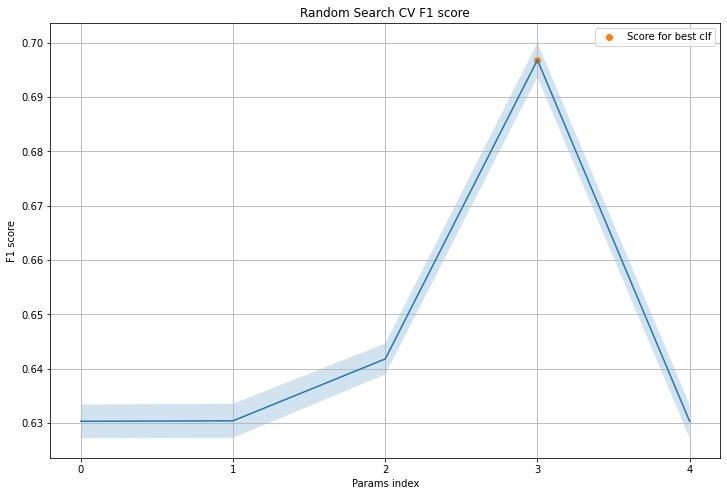

In [63]:
plot_search_cv_scores(random_searcher, 'Random')

In [0]:
ovr_clf = random_searcher.best_estimator_

Напишем классифкатор-обертку, калибрующий предсказания для $\text{OVR}$ мульти-лэйбел подхода

In [0]:
class MultiLabelOVRCalibratedClasiifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf=OneVsRestClassifier(SGDClassifier()), cv=5, calib_method='isotonic'):
        self.clf = clf
        self.cv = cv
        self.calib_method = calib_method

    def fit(self, X, Y):
        assert len(Y.shape) == 2 and np.all((Y == 0) | (Y == 1)), 'Y should be in MultilabelBinarize form'
        
        self.clf.fit(X, Y)
        assert hasattr(self.clf, 'estimators_'), 'Base classifier should be OVR'

        self.calib_clfs_ = []

        for i, estimator in enumerate(self.clf.estimators_):
            y = Y[:, i]
            calib_clf_cv = CalibratedClassifierCV(self.clf, method=self.calib_method, cv=self.cv)
            calib_clf_cv.fit(X, y)
            self.calib_clfs_.append(calib_clf_cv)

        return self
    
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        probs_cv = None

        for calib_clf_cv in self.calib_clfs_:
            probs_i_cv = calib_clf_cv.predict_proba(X)[:, 1].reshape(-1, 1)
            if probs_cv is None:
                probs_cv = probs_i_cv
            else:
                probs_cv = np.hstack((probs_cv, probs_i_cv))

        return probs_cv

In [0]:
calib_ovr_clf = MultiLabelOVRCalibratedClasiifier(ovr_clf, cv=5, calib_method='isotonic')

In [67]:
calib_ovr_clf.fit(Xtrain_vect, Ytrain_bin)

MultiLabelOVRCalibratedClasiifier(calib_method='isotonic',
                                  clf=OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                                              class_weight='balanced',
                                                                              dual=True,
                                                                              fit_intercept=True,
                                                                              intercept_scaling=1,
                                                                              loss='hinge',
                                                                              max_iter=10000.0,
                                                                              multi_class='ovr',
                                                                              penalty='l2',
                                                                              random_state

In [0]:
ovr_probs = calib_ovr_clf.predict_proba(Xtest_vect)

Подберем пороги для $\text{F1}$ метрики 

In [0]:
class OptimalF1ScorePrediction:
    def __init__(self, probs):
        self.probs = probs

    @staticmethod
    def prevent_zero_preds(probs, preds):
        # if no True prediction for current tag
        zero_pred = ~preds.any(axis=1) 

        # forced assign max probability tag to avoid zero prediction
        preds[zero_pred, probs[zero_pred].argmax(axis=1)] = True

        return preds

    def _f1_single_tag_threshold_score(self, w, i, Y_test):
        threshold = np.repeat(0.5, 68)
        threshold[i] = w
        preds = self.probs > threshold
        preds = self.prevent_zero_preds(self.probs, preds)
        return -f1_score(Y_test, preds, average='samples')

    def _get_optimal_f1_threshold(self, Y_test):
      self.thresholds_ = []  
      for i in range(68):
          opt_score = opt.minimize_scalar(self._f1_single_tag_threshold_score, args=(i, Y_test),\
                                          bounds=(0, 1), method='Bounded')
          self.thresholds_.append(opt_score.x)

    def get_optimal_threshold(self):
        return self.thresholds_

    def get_prediction(self, Y_test):
        self._get_optimal_f1_threshold(Y_test)
        preds = self.probs > self.thresholds_
        preds = self.prevent_zero_preds(self.probs, preds)
        return preds

In [0]:
ovr_preds = OptimalF1ScorePrediction(ovr_probs).get_prediction(Ytest_bin)

In [71]:
f1_score(Ytest_bin, ovr_preds, average='samples')

0.7618857142857142

Посмотрим на предсказания и сравним их с тестовыми

In [0]:
def create_expected_preds_df(preds, Ytest):
    pred_tags = pd.Series(mlb.inverse_transform(preds)).apply(lambda pred:\
                                                              tags_encoder.inverse_transform(pred))
    test_tags = Ytest.apply(lambda pred:\
                            tags_encoder.inverse_transform(pred))\
                            .reset_index(drop=True)
    expected_preds = pd.concat((test_tags, pred_tags), axis=1)
    expected_preds.columns = ['Expected', 'Prediction']
    return expected_preds

In [0]:
def show_some_preds(expected_preds, n=10):
    idx = np.random.choice(np.arange(expected_preds.shape[0]), size=n)
    display(expected_preds.iloc[idx])

In [0]:
ovr_expected_preds = create_expected_preds_df(ovr_preds, Ytest)

In [83]:
show_some_preds(ovr_expected_preds)

,Expected,Prediction
8021,"[android, java, kotlin]",[android]
5175,"[ios, swift]","[ios, swift]"
6719,"[keras, python]","[keras, python, tensorflow]"
5551,"[numpy, python]","[numpy, python]"
485,[ruby-on-rails],[ruby-on-rails]
2537,[c#],[c#]
1382,[java],[java]
9335,"[javascript, vue.js]",[javascript]
5899,[amazon-web-services],[amazon-web-services]
1324,[python],[python]


### Classifier Chain

Определим классификатор на базе $\text{LogisticRegression}$, представляющий собой усреднение по нескольким $\text{ClassifierChain}$ с рандомным порядком целевых столбцов

In [0]:
class AverageClassifierChain(BaseEstimator, ClassifierMixin):
    def __init__(self, clf=SGDClassifier(loss='log', class_weight='balanced', random_state=123),\
                 cv=5, n_clf=5):
        self.clf = clf
        self.cv = cv
        self.n_clf = n_clf

    def fit(self, X, Y):
        self.chains_ = [ClassifierChain(self.clf, order='random', cv=self.cv, random_state=i)\
                        for i in range(self.n_clf)]
        for chain in self.chains_:
            chain.fit(X, Y)

        return self
    
    def predict(self, X):
        pred_chains = [chain.predict(X) for chain in self.chains_]
        return np.around(np.mean(pred_chains, axis=0))

    def predict_proba(self, X):
        probs_chains = [chain.predict_proba(X) for chain in self.chains_]
        return np.mean(probs_chains, axis=0)


In [0]:
average_chain_clf = AverageClassifierChain()

In [223]:
average_chain_clf.fit(Xtrain_vect, Ytrain_bin)

AverageClassifierChain(clf=SGDClassifier(alpha=0.0001, average=False,
                                         class_weight='balanced',
                                         early_stopping=False, epsilon=0.1,
                                         eta0=0.0, fit_intercept=True,
                                         l1_ratio=0.15, learning_rate='optimal',
                                         loss='log', max_iter=1000,
                                         n_iter_no_change=5, n_jobs=None,
                                         penalty='l2', power_t=0.5,
                                         random_state=123, shuffle=True,
                                         tol=0.001, validation_fraction=0.1,
                                         verbose=0, warm_start=False),
                       cv=5, n_clf=5)

In [0]:
chain_probs = average_chain_clf.predict_proba(Xtest_vect)

In [0]:
chain_preds = OptimalF1ScorePrediction(chain_probs).get_prediction(Ytest_bin)

In [231]:
f1_score(Ytest_bin, chain_preds, average='samples')

0.7380138095238095

In [0]:
chain_expected_preds = create_expected_preds_df(chain_preds, Ytest)

In [238]:
show_some_preds(chain_expected_preds)

,Expected,Prediction
2663,[python],[python]
9718,[c],[c]
266,[javascript],[javascript]
1465,[windows],[c++]
5883,[r],[r]
7019,"[html, javascript]","[html, javascript]"
1432,[python],[python]
8679,[css],[css]
794,"[excel, vba]","[excel, vba]"
984,[javascript],[javascript]


### Label Powerset

Сведем задачу к мультиклассовой, представив каждую уникальную комбинацию тэгов из обучающей выборки как отдельный класс

In [0]:
LP_encoder = LabelEncoder()

In [0]:
Ytrain_str = Ytrain.apply(lambda tags: ' '.join(tags_encoder.inverse_transform(tags)))

In [0]:
Ytest_str = Ytest.apply(lambda tags: ' '.join(tags_encoder.inverse_transform(tags)))

In [75]:
LP_encoder.fit(Ytrain_str)

LabelEncoder()

In [286]:
print(f'LP classes number: {len(LP_encoder.classes_)}')

LP classes number: 156


In [0]:
Ytrain_LP = LP_encoder.transform(Ytrain_str)

In [0]:
Ytest_LP = LP_encoder.transform(Ytest_str)

Для решения мультиклассовой задачи воспользуемся библиотекой $\text{Vowpal Wabbit}$

In [0]:
!apt-get install libboost-program-options-dev zlib1g-dev libboost-python-dev vowpal-wabbit

!pip install vowpalwabbit

Приведем данные к $\text{VW}$ формату

In [0]:
def data_to_vw_format(X, Y, filename):
    n_samples, n_features = X.shape
    with io.BytesIO() as stream:
        dump_svmlight_file(X, np.zeros(n_samples), stream)
        rows = stream.getvalue().decode('ascii').split('\n')[:-1]
    
        with open(filename, 'w+') as file:
            for i, row in enumerate(rows):
                label = Y[i] + 1 if Y is not None else ''
                features = row.split('0 ', 1)[1]
                file.write(f'{label} | {features} \n')

In [0]:
data_to_vw_format(Xtrain_vect, Ytrain_LP, 'train/data_train_vw.csv')

In [0]:
data_to_vw_format(Xtest_vect, Ytest_LP, 'train/data_test_vw.csv')

In [98]:
!head -n 1 train/data_train_vw.csv

58 | 4439:0.6978917235094478 6794:0.4943263537813979 7958:0.5182553407483619 8419:0.3614460903316675 8675:0.1322744081971143 8683:0.1885992385324841 9708:0.1773547619221054 9710:0.2308605130027169 10630:0.08455964966487813 10900:0.2036851574655714 11897:0.1088890442835192 11920:0.2626670738613484 12417:0.09998011002241929 12466:0.2394080605038651 13094:0.2522955776786593 13212:0.1151313945664122 15090:0.1052372574452016 15120:0.2586504086593265 15475:0.1267796529744616 15478:0.2049693255989216 15519:0.253406516474153 15538:0.2405821256205951 15879:0.10552459255485 16007:0.2626670738613484 16672:0.09743018454247444 16748:0.2777074250758197 16769:0.1288103225976827 17358:0.1278252164749827 17421:0.04041295584853315 17424:0.1532989769525635 17425:0.1533453059451739 17428:0.02752295006009257 17430:0.09227186784599008 17432:0.1640478736195255 17440:0.1718007735188808 17598:0.2887786070972422 17599:0.2820181771142729 18632:0.3377879976163959 19260:0.3760242361523639 19676:0.4626159386656423 

Обучим логистическую регрессиию

In [110]:
!vw -d train/data_train_vw.csv --l2 1e-07 -f train/log_model.vw --oaa 156 --passes 5 --loss_function=logistic --probabilities -c -k -b 24

using l2 regularization = 1e-07
final_regressor = train/log_model.vw
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = train/data_train_vw.csv.cache
Reading datafile = train/data_train_vw.csv
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       58   1( 1%)       50
1.000000 1.000000            2            2.0      108  58( 1%)       67
1.000000 1.000000            4            4.0       37  82( 1%)      122
1.000000 1.000000            8            8.0      137  37( 1%)      127
0.937500 0.875000           16           16.0       37 126( 1%)      193
0.937500 0.937500           32           32.0      147  79( 1%)       77
0.937500 0.937500           64           64.0       17 137( 1%)      108
0.875000 0.812500          128          128.0      134 126( 2%)       

Применим к тестовым данным

In [0]:
!vw -i train/log_model.vw --loss_function=logistic --probabilities -t -d train/data_test_vw.csv -p train/probs.csv --quiet

In [0]:
vw_probs = pd.read_csv('train/probs.csv', sep=' ',  header=None)

In [0]:
vw_probs = vw_probs.apply(lambda col: col.str.split(':').apply(lambda lst: np.float64(lst[1])), axis=0)

Преобразуем полученные вероятности комбинаций тэгов в вероятности появления каждого тега

In [0]:
def LP_probs_to_tags_probs(LP_probs, tags_count):
    tags_probs = np.zeros((LP_probs.shape[0], tags_count))
    for row in range(len(LP_probs)):
        assignment = LP_probs[row]
        for combination_id in range(len(assignment)):
            tags = tags_encoder.transform(LP_encoder.inverse_transform([combination_id])[0].split())
            for tag in tags:
                tags_probs[row, tag] += assignment[combination_id]

    return tags_probs

In [0]:
vw_tags_probs = LP_probs_to_tags_probs(vw_probs.values, len(tags))

In [0]:
vw_preds = OptimalF1ScorePrediction(vw_tags_probs).get_prediction(Ytest_bin)

In [294]:
f1_score(Ytest_bin, vw_preds, average='samples')

0.7182133333333334

In [0]:
vw_expected_preds = create_expected_preds_df(vw_preds, Ytest)

In [296]:
show_some_preds(vw_expected_preds)

,Expected,Prediction
9066,[python],[python]
141,"[python, tensorflow]","[python, tensorflow]"
1467,[c#],[c#]
8454,[c#],[c#]
6059,"[android, java]",[java]
225,"[numpy, python]","[pandas, python]"
1749,[php],[php]
1962,"[php, wordpress]",[wordpress]
3119,"[javascript, typescript]",[javascript]
7010,"[.net, c#]",[asp.net-core]
